In [51]:
!pip install sentinelsat
!pip install geopandas
!pip install rasterio
!pip install pycrs

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sentinelsat import SentinelAPI
import folium
import shapely
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
from shapely.geometry import shape
from shapely.geometry import box
from shapely.ops import cascaded_union
import urllib.request as request
import json
from datetime import datetime
from datetime import timedelta
import zipfile
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import os
from fiona.crs import from_epsg
from skimage import exposure
from PIL import Image
import matplotlib
import pycrs
import shutil
import time
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import imageio
import warnings

warnings.filterwarnings('ignore')

In [0]:
url = 'https://water.blue-dot-observatory.com/api/waterbodies/'
water_body_data = json.loads(request.urlopen(url).read().decode())

In [54]:
len(water_body_data)

13151

Get downloaded ids

In [0]:
downloaded = []
for file in os.listdir('/content/drive/My Drive/Water Bodies Satellite Images/Images'):
  idx = file.split('_')[2]
  downloaded.append(idx)

Extract Geometries

In [0]:
def extract_geometries(max_records):
  current_record = 18290
  names = []
  countries = []
  latitudes = []
  longitudes = []
  geometries = []
  idxs = []
  while len(names) < max_records:
    water_url = f'https://water.blue-dot-observatory.com/api/waterbodies/{current_record}/index.html'
    try:
      water_body_data = json.loads(request.urlopen(water_url).read().decode())
      names.append(water_body_data['properties']['name'])
      countries.append(water_body_data['properties']['country'])
      latitudes.append(water_body_data['properties']['lat'])
      longitudes.append(water_body_data['properties']['long'])
      geometries.append(water_body_data['nominal_outline']['geometry'])
      idxs.append(water_body_data['properties']['id'])
    except:
      pass
    current_record += 1
      
  #Create Dataframe
  water_bodies = pd.DataFrame({'Name':names,
                             'Country':countries,
                             'Latitude':latitudes,
                             'Longitude':longitudes,
                             'Geometry':geometries,
                             'id':idxs})
  
  return water_bodies

Download from satellite

In [0]:
def download_from_satellite(i, df):
  #Create simple shape
  water_body_geometry = df.iloc[i]['Geometry']
  water_body_shape = shape(water_body_geometry)
  shape_simplified = box(water_body_shape.bounds[0], water_body_shape.bounds[1], water_body_shape.bounds[2], water_body_shape.bounds[3])

  #Download data
  today = datetime.today()
  one_year_ago = today - timedelta(days=365)
  today = today.strftime('%Y%m%d')
  results = api.query(shape_simplified, date = (one_year_ago, today), platformname = 'Sentinel-2', processinglevel = 'Level-1C', cloudcoverpercentage = (0,5))
  results_gdf = api.to_geodataframe(results).sort_values(['cloudcoverpercentage'], ascending=True)
  uuid = results_gdf.iloc[0]['uuid']
  filename = '/content/' + results_gdf.iloc[0]['title'] + '.zip'
  data = api.download(uuid)

  #Extract data
  with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/My Drive/Satellite Data/')
  folder = os.listdir('/content/drive/My Drive/Satellite Data/' + data['title'] + '.SAFE/GRANULE/')[0]
  directory = '/content/drive/My Drive/Satellite Data/' + data['title'] + '.SAFE/GRANULE/' + folder + '/IMG_DATA/'

  #Delete ZIP file
  os.remove(filename)

  return directory, shape_simplified

Image Processing

In [0]:
def image_processing(directory, shape_simplified, output_directory, i):
  main_directory = output_directory
  output_directory = output_directory + 'Images'
  #Open individual RGB bands
  for f in os.listdir(directory):
    if '_B02' in f:
      band_2 = rio.open(directory + f)
      with rio.open(directory + f) as src:
        b2 = src.read(1)
    elif '_B03' in f:
      band_3 = rio.open(directory + f)
      with rio.open(directory + f) as src:
        b3 = src.read(1)
    elif '_B04' in f:
      band_4 = rio.open(directory + f)
      with rio.open(directory + f) as src:
        b4 = src.read(1)
  
  #Save complete image
  with rio.open('RGB.tiff','w',driver='Gtiff', width=band_4.width, height=band_4.height, count=3,crs=band_4.crs,transform=band_4.transform, dtype=band_4.dtypes[0]) as rgb:
    rgb.write(band_4.read(1),1) 
    rgb.write(band_3.read(1),2) 
    rgb.write(band_2.read(1),3) 
    rgb.close()

  #Clip image
  geo = gpd.GeoDataFrame({'geometry': shape_simplified}, index=[0], crs=from_epsg(4326))
  src = rio.open('/content/RGB.tiff')
  geo = geo.to_crs(crs=src.crs.data)
  coordinates = [json.loads(geo.to_json())['features'][0]['geometry']]
  out_img, out_transform = mask(dataset=src, shapes=coordinates, crop=True)
  out_meta = src.meta.copy()
  epsg_code = int(src.crs.data['init'][5:])
  out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()
                 }
                         )
  with rio.open('/content/output.tiff', "w", **out_meta) as dest:
    dest.write(out_img)
  
  #Normalize and merge color bands
  img = rio.open('output.tiff')
  image = np.array([img.read(1), img.read(2), img.read(3)]).transpose(1,2,0)
  p2, p98 = np.percentile(image, (2,98))
  image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000
  output_filename = output_directory + '/water_body_' + str(water_bodies['id'][i]) + '.jpg'
  matplotlib.image.imsave(output_filename, image)

  return output_filename

Delete raster files

In [0]:
def delete_trash():
  for trash in os.listdir('/content/drive/My Drive/Satellite Data/'):
    shutil.rmtree('/content/drive/My Drive/Satellite Data/' + trash)

  os.remove('/content/NDWI.tif')
  os.remove('/content/RGB.tiff')
  os.remove('/content/output.tiff')

Create mask

In [0]:
def create_mask(directory, output_directory, i):
  output_directory = output_directory + 'Masks'
  #Create mask
  for f in os.listdir(directory):
    if '_B03' in f:
      with rio.open(directory + f) as src:
        b3 = src.read(1)
    elif '_B08' in f:
      with rio.open(directory + f) as src:
        b8 = src.read(1)
  NDWI = (b8.astype(float) - b3.astype(float)) / (b8 + b3)
  out_meta = src.meta
  out_meta.update(driver = 'GTiff', dtype=rio.float32, count = 1)
  with rio.open('NDWI.tif', 'w', **out_meta) as dst:
    dst.write_band(1, NDWI.astype(rio.float32))
  src = rio.open("NDWI.tif")
  water_body_shape = shape(water_bodies.iloc[i]['Geometry'])
  polygons = [water_body_shape]
  boundary = gpd.GeoSeries(cascaded_union(polygons))
  geo = gpd.GeoDataFrame({'geometry': boundary}, index=[0], crs=from_epsg(4326))
  geo = geo.to_crs(crs=src.crs.data)
  coordinates = [json.loads(geo.to_json())['features'][0]['geometry']]
  out_img, out_transform = mask(dataset=src, shapes=coordinates, crop=True)
  out_meta = src.meta.copy()
  epsg_code = int(src.crs.data['init'][5:])
  out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()
                 }
                         )
  with rio.open('/content/output.tiff', "w", **out_meta) as dest:
    dest.write(out_img)

  #Normalize and merge color bands
  img = rio.open('output.tiff')
  show(img)
  image = np.array([img.read(1)])
  p2, p98 = np.percentile(image, (2,98))
  image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000
  image[image>0] = 1
  output_filename = output_directory + '/water_body_' + str(water_bodies['id'][i]) + '.jpg'
  image = np.rollaxis(image, 0, 3)
  image = np.squeeze(image,axis=2)
  matplotlib.image.imsave(output_filename, image, cmap='Greys_r')
  return output_filename
  

Complete Workflow

Image 1 of 1: Lake Travis, United States of America. ETA: N/A min. Total: N/A min.


Downloading: 100%|██████████| 869M/869M [00:45<00:00, 19.3MB/s]
MD5 checksumming: 100%|██████████| 869M/869M [00:02<00:00, 422MB/s]


Reading RGB bands


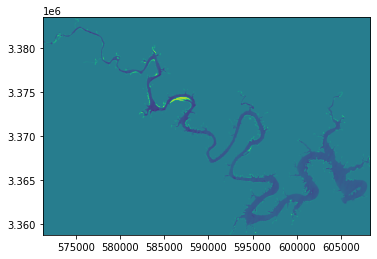

(1, 2462, 3709)
(2462, 3709, 1)


Done!


In [63]:
output_directory = '/content/drive/My Drive/Water Bodies Satellite Images/'

#Extract geometries and create dataframe
water_bodies = extract_geometries(1)

#Log in to Sentinel Hub
with open('/content/drive/My Drive/Sentinel Hub Credentials/login_info.txt') as file:
  credentials = file.readlines()
  credentials = [credential.strip() for credential in credentials]
api = SentinelAPI(credentials[0], credentials[1], 'https://scihub.copernicus.eu/dhus')

#Download and unzipe file
t0 = time.time()
for i in range(0, len(water_bodies)):
  if water_bodies['id'][i] not in downloaded:
    #Calculate ETA
    t1 = time.time()
    if i != 0 :
      total = round((t2 - t0)/60,2)
      eta = round(total/(i) * (len(water_bodies)-i))
    else:
      eta = 'N/A'
      total = 'N/A'

    name = water_bodies.iloc[i]['Name']
    country = water_bodies.iloc[i]['Country']
    print(f'Image {i+1} of {len(water_bodies)}: {name}, {country}. ETA: {eta} min. Total: {total} min.')
    directory, shape_simplified = download_from_satellite(i, water_bodies)

    #Clip image, merge and normalize color bands
    output_filename = image_processing(directory, shape_simplified, output_directory, i)

    #Create mask
    output_mask = create_mask(directory, output_directory, i)

    #Delete raster files
    delete_trash()

    #Rotate and resize image
    #print('Resizing image')
    #image_1 = Image.open(output_filename)
    #image_2 = Image.open(output_mask)
    #x = (image_1.size[0] - image_2.size[0])//2
    #y = (image_1.size[1] - image_2.size[1])//2
    #image_1_crop = image_1.rotate(0.3).crop((x, y, image_2.size[0]+x, image_2.size[1]+y))
    #image_1_crop.save(output_filename)

    t2 = time.time()
    print('\n')
  else:
    idx = water_bodies['id'][i]
    print(f'ID: {idx} already downloaded')

print('Done!')